In [12]:
from numpy import *
import numpy as np
import matplotlib.pyplot as plt

In [13]:
######训练样本######
def load_simple_data():
    data_mat = np.matrix([[1.0,2.1],[2.0,1.1],[1.3,1.0],[1.0,1.0],[2.0,1.0]])
    class_labels=[1.0,1.0,-1.0,-1.0,1.0]
    return data_mat,class_labels

In [14]:
######根据阈值判断每个特征的输出值######
#ret_array初始化时不能全1或-1
def stump_classify(data_matrix,dimen,threshval,thresh_ineq):
    ret_array=zeros((shape(data_matrix)[0],1))
    if thresh_ineq=="lt":
        ret_array[data_matrix[:,dimen]<=threshval]=-1.0
    else:
        ret_array[data_matrix[:,dimen]>threshval]=1.0
    return ret_array    

In [15]:
######实现单层决策树######
#lt_predicted_arr存储小于等于阈值的输出值，gt_predicted_arr存储大于阈值的输出值
def build_stump(data_arr,class_labels,D):
    data_matrix=mat(data_arr)   #数据集
    label_mat=mat(class_labels).T  #标签集
    m,n=shape(data_matrix)   #数据集的行、列
    num_steps=10.0      #用于设置划分点
    best_stump={}
    best_class_est=mat(zeros((m,1)))
    min_error=inf
    
    for i in range(n):
        range_min=data_matrix[:,i].min()   #数据集中某一列的最小值
        range_max=data_matrix[:,i].max()   #数据集中某一列的最大值
        step_size=(range_max-range_min)*1.0/num_steps   #用于设置划分点
        for j in range(-1,int(num_steps)+1):
            thresh_val=(range_min+float(j)*step_size)   #计算其中一个划分点
            lt_predicted_arr=zeros((m,1))     #获得析域不等号的值
            gt_predicted_arr=zeros((m,1))     #获得大于不等号的值
            predicted_arr=zeros((m,1))        #获得最终的预测值
            for inequal in ["lt","gt"]:
                preducted_vals=stump_classify(data_matrix,i,thresh_val,inequal)
                if inequal=='lt':
                    lt_predicted_arr=preducted_vals
                else:
                    gt_predicted_arr=preducted_vals
            for k in range(m):
                predicted_arr[k] = lt_predicted_arr[k]
                if(gt_predicted_arr[k] != 0):
                    predicted_arr[k] = gt_predicted_arr[k]
            err_arr = mat(ones((m, 1)))
            err_arr[predicted_arr == label_mat] = 0
            weight_error = D.T * err_arr
            print("min_error = %0.5f, split: dim %d, thresh %0.2f,the weighted error is %0.3f" %(min_error, i, thresh_val, weight_error))
            if(weight_error < min_error):
                min_error = weight_error
                best_class_est = predicted_arr.copy()
                best_stump["dim"] = i
                best_stump["thresh"] = thresh_val
                best_stump["class_est"] = best_class_est
    return best_stump,min_error,best_class_est

In [16]:
###根据单层决策树得到一个弱分类器保存在列表中
###根据得到的弱分类器输出的预测值和原始值修改权重，减小误差小的点的权重，增大误差大的点的权重。最后误差率等于0则停止迭代。
def adaboost_train_DS(data_arr, class_labels, num_it = 40):
    weak_class_arr = []
    m = shape(data_arr)[0]
    D = mat(ones((m, 1)) / m)
    agg_class_est = mat(zeros((m, 1)))
    counts = 0

    for i in range(num_it):
        best_stump,error,class_est = build_stump(data_arr, class_labels, D)
        print("D: ", D.T)
        alpha = float(0.5 * log((1.0 - error) / error))
        best_stump["alpha"] = alpha
        weak_class_arr.append(best_stump)
        print("class_est: ", class_est.T)
        expon = multiply(-1 * alpha * mat(class_labels).T, class_est)
        D = multiply(D, exp(expon))
        D = D / D.sum()
        agg_class_est += alpha * class_est  #预测值
        print("agg_class_est: ", agg_class_est.T)
        agg_errors = multiply(sign(agg_class_est) != mat(class_labels).T, ones((m, 1)))
        error_rate = agg_errors.sum() / m
        print("total error: ", error_rate)
        counts += 1
        if(error_rate == 0.0):
            break
    return weak_class_arr,counts

In [17]:
###弱分类器：根据每一个弱分类器阈值，输出每个特征的输出值。
def Gx(data_matrix, reshval):
    m = shape(data_matrix)[0]
    result_data = mat(ones((m, 1)))
    result_data[data_matrix[:, 0] <= reshval] = -1.0
    result_data[data_matrix[:, 0] > reshval] = 1.0
    return result_data

In [18]:
###根据输出数据，输出实际预测值。
def ada_classfiy(input_data, weak_class_arr, counts):
    data_matrix = mat(input_data)
    m,n = shape(data_matrix)  
    agg_class_est = mat(zeros((m, 1)))
    for j in range(n):
        for i in range(len(weak_class_arr)):
            agg_class_est += (weak_class_arr[i]["alpha"] * (Gx(input_data[:, j], weak_class_arr[i]["thresh"])).T).T
    print(agg_class_est)
    return sign(agg_class_est)

In [19]:
###画图###
def experiment_plot(data_matrix, agg_class_est):
    data_arr_in = data_matrix.getA()
    label_arr_in = agg_class_est.getA()
    m,n = shape(data_matrix)

    for i in range(m):
        if(label_arr_in[i, 0] == -1):
            plt.plot(data_arr_in[i, 0], data_arr_in[i, 1], "ob")
        elif(label_arr_in[i, 0] == 1):
            plt.plot(data_arr_in[i, 0], data_arr_in[i, 1], "or")

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

min_error = inf, split: dim 0, thresh 0.90,the weighted error is 0.400
min_error = 0.40000, split: dim 0, thresh 1.00,the weighted error is 0.400
min_error = 0.40000, split: dim 0, thresh 1.10,the weighted error is 0.400
min_error = 0.40000, split: dim 0, thresh 1.20,the weighted error is 0.400
min_error = 0.40000, split: dim 0, thresh 1.30,the weighted error is 0.200
min_error = 0.20000, split: dim 0, thresh 1.40,the weighted error is 0.200
min_error = 0.20000, split: dim 0, thresh 1.50,the weighted error is 0.200
min_error = 0.20000, split: dim 0, thresh 1.60,the weighted error is 0.200
min_error = 0.20000, split: dim 0, thresh 1.70,the weighted error is 0.200
min_error = 0.20000, split: dim 0, thresh 1.80,the weighted error is 0.200
min_error = 0.20000, split: dim 0, thresh 1.90,the weighted error is 0.200
min_error = 0.20000, split: dim 0, thresh 2.00,the weighted error is 0.600
min_error = 0.20000, split: dim 1, thresh 0.89,the weighted error is 0.400
min_error = 0.20000, split: d

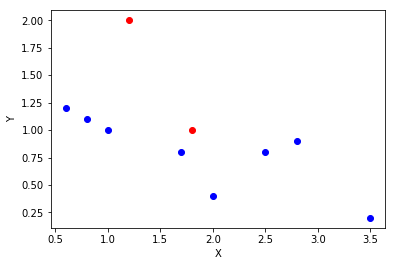

In [20]:
def main():
    #D = mat(ones((5, 1)) / 5.0)
    data_mat,class_labels = load_simple_data()
    #build_stump(data_mat, class_labels, D)
    weak_class_arr,counts = adaboost_train_DS(data_mat, class_labels)
    print("**************************")
    data_mat2 = matrix([[1.2, 2.0],
                       [1.0, 1.0],
                       [0.6, 1.2],
                       [0.8, 1.1],
                       [1.8, 1.0],
                       [2.0, 0.4],
                       [1.7, 0.8],
                       [3.5, 0.2],
                       [2.5, 0.8],
                       [2.8, 0.9]])
    agg_class_est = ada_classfiy(data_mat2, weak_class_arr, counts)
    print("--------------------------")
    print(agg_class_est)
    experiment_plot(data_mat2, agg_class_est)

main()